In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchaudio
import PIL
from torch.functional import F
import IPython
from IPython.display import Audio, display

Decargando nuestra data: Speech Commands

In [ ]:
sc_train_ds = torchaudio.datasets.SPEECHCOMMANDS("./",download=True,subset="training")
sc_test_ds = torchaudio.datasets.SPEECHCOMMANDS("./",download=True,subset="testing")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
speech_labels = ["Backward",
"Bed",
"Bird",
"Cat",
"Dog",
"Down",
"Eight",
"Five",
"Follow",
"Forward",
"Four",
"Go",
"Happy",
"House",
"Learn",
"Left",
"Marvin",
"Nine",
"No",
"Off",
"On",
"One",
"Right",
"Seven",
"Sheila",
"Six",
"Stop",
"Three",
"Tree",
"Two",
"Up",
"Visual",
"Wow",
"Yes",
"Zero"]
speech_dict = {k.lower():v for v,k in enumerate(speech_labels)}

# Usemos Convolucion 1D para speech recognition

Preparando el Dataset

In [ ]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self,raw_data):
    self.raw_data = raw_data
    self.resampling = torchaudio.transforms.Resample(new_freq=8000)
  
  def __len__(self):
    return len(self.raw_data)
  
  def __getitem__(self,idx):
    x, _, y, _, _ = self.raw_data[idx]
    C, L = x.shape
    if L!=16000:
      x = F.pad(x,(0,16000 - L),mode="constant",value=0.0)
    return self.resampling(x), speech_dict[y]

In [ ]:
train_ds = MyDataset(sc_train_ds)
test_ds = MyDataset(sc_test_ds)

In [ ]:
x, l = next(iter(train_ds))

In [ ]:
x.shape

torch.Size([1, 8000])

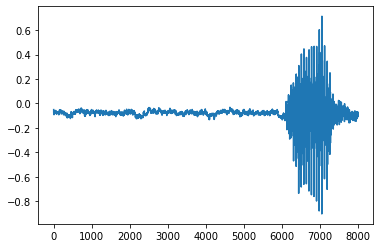

In [ ]:
plt.plot(x.numpy().reshape(-1))

Creamos nuestro DataLoader

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32,shuffle=True)

Definamos nuestro modelo

In [ ]:
for x,y in test_dl:
  print(x.shape)
  print(y)
  break

torch.Size([32, 1, 8000])
tensor([25, 10, 12,  1,  6,  2,  3, 32,  8, 19, 29, 26, 30, 27, 30,  6, 21, 22,
        15, 20, 30,  9, 20, 21, 25, 33, 26,  6, 20, 15, 13, 11])


In [ ]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = nn.Sequential(
    nn.Conv1d(1,32,100,stride=40,bias=False),
    nn.BatchNorm1d(32),
    nn.ReLU(inplace=True),
    nn.Conv1d(32,64,3,bias=False),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Conv1d(64,64,3,bias=False),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool1d(4),
    nn.Flatten(),
    nn.Linear(64*11,35)
).to(dev)

Entrenando nuestro modelo

In [ ]:
def evaluate(model, loader, crit):
  model.eval()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in loader:
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100* corrects / total
  avg_loss /= len(loader)  
  return avg_loss, acc

def train_one_epoch(model, train_loader, crit, optim):
  model.train()
  total = 0
  corrects = 0
  avg_loss = 0
  for x, y in train_loader:
    optim.zero_grad()
    x = x.to(dev)
    y = y.to(dev)
    o = model(x)
    loss = crit(o,y)
    avg_loss += loss.item()
    loss.backward()
    optim.step()
    corrects += torch.sum(torch.argmax(o,axis=1) == y).item()
    total += len(y)
  acc = 100 * corrects / total
  avg_loss /= len(train_loader)
  return avg_loss, acc

def train(model, train_loader, test_loader, crit, optim, epochs = 20):
  for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader,crit, optim)
    test_loss, test_acc = evaluate(model, test_loader, crit)
    print(f"epoch: {epoch}, train loss: {train_loss}, train acc: {train_acc}%, test loss: {test_loss}, test acc: {test_acc}%")

In [ ]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)
train(model,train_dl, test_dl, crit,optim,epochs=10)

epoch: 0, train loss: 2.377115792009086, train acc: 33.67396249543274%, test loss: 1.8036279144675234, test acc: 49.650159018627896%
epoch: 1, train loss: 1.5196780640390304, train acc: 57.2033049279257%, test loss: 1.5720648687592773, test acc: 55.0658791458428%
epoch: 2, train loss: 1.221843374923973, train acc: 65.6919250851573%, test loss: 1.2592223208657531, test acc: 63.752839618355296%
epoch: 3, train loss: 1.0550669895577753, train acc: 70.26154190681612%, test loss: 1.1218896626039994, test acc: 69.45933666515221%
epoch: 4, train loss: 0.9515540603081925, train acc: 73.23644849899226%, test loss: 0.9969441804948241, test acc: 71.84915947296683%
epoch: 5, train loss: 0.8832956628135067, train acc: 75.04449394764447%, test loss: 1.0640648035115974, test acc: 71.20399818264426%
epoch: 6, train loss: 0.8276392451317511, train acc: 76.5071956437184%, test loss: 1.5212935529822527, test acc: 62.63516583371195%
epoch: 7, train loss: 0.7811935854848154, train acc: 77.6728781396226%, t

In [ ]:
torch.save(model.state_dict(),"speech_commnad_model_conv1d.ckpt")

In [ ]:
model.load_state_dict(torch.load("speech_commnad_model_conv1d.ckpt"))
model.eval()

Sequential(
  (0): Conv1d(1, 32, kernel_size=(100,), stride=(40,), bias=False)
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), bias=False)
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), bias=False)
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=704, out_features=35, bias=True)
)

In [ ]:
idx = 2020
audio_ = Audio(data=sc_train_ds[idx][0][0].numpy(),rate=16000)
pred = torch.argmax(model(train_ds[idx][0].reshape(1,1,8000).to(dev)).cpu(),axis=1)[0].item()
print(speech_labels[pred])
display(audio_)

Bed


# Usemos Espectrogramas y Convolucion 2D para speech recognition

# Transformada de Fourier

In [ ]:
t0=0
tf=5
N = 100

sample_freq = N / (tf - t0)
sample_w = 2 * torch.pi * sample_freq
dummy_x = torch.linspace(t0,tf,N)
w1, w2, w3 = 2, 10 , 40
dummy_y = 2*torch.sin(w1 * dummy_x) + 2*torch.cos(w2 *dummy_x) +2*torch.sin(w3 * dummy_x)

In [ ]:
dummy_fft = torch.fft.fft(dummy_y)

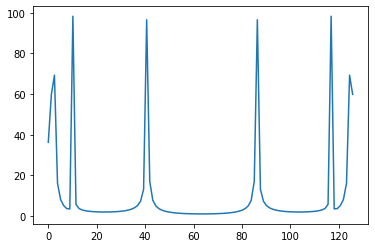

In [ ]:
plt.plot(torch.linspace(0,sample_w,100), dummy_fft.abs())

In [ ]:
sample = sc_test_ds[10][0][0]

In [ ]:
sample_fft = torch.fft.fft(sample).abs()

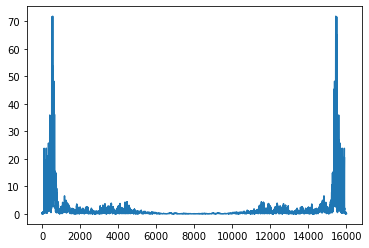

In [ ]:
plt.plot(sample_fft)

# Espectrograma

In [ ]:
fft_per_window = []
for i in range(16000 // 80):
  tmp = sample[i*80: 80*i + 160]
  fft_per_window.append(torch.fft.fft(tmp).abs().numpy()[:80])
fft_per_window = np.array(fft_per_window).T

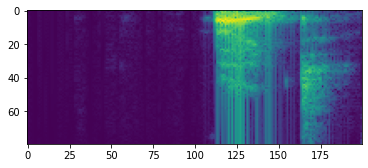

In [ ]:
plt.imshow(np.log(fft_per_window + 1e-3))

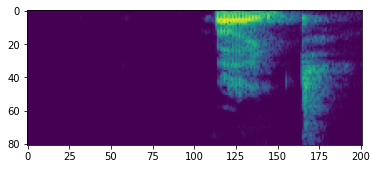

In [ ]:
plt.imshow(np.log(torchaudio.transforms.Spectrogram(n_fft=160)(sample).numpy()+1e-5))

Backward
torch.Size([1, 8000])
-11.512923
Backward
torch.Size([1, 8000])
-11.512925


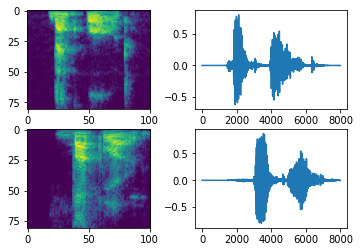

In [ ]:
count = 0
idx = 0
fig, axs = plt.subplots(2,2)
for x, l in test_ds:
  if l ==idx :
    print(speech_labels[l])
    print(x.shape)
    N, l = x.shape
    y = torchaudio.transforms.Spectrogram(n_fft=160)(x)
    I=np.log(y[0].numpy() + 1e-5)
    print(np.min(I))
    axs[count,0].imshow(I)
    axs[count,1].plot(x[0].numpy())
    count += 1
    if count == 2:
      break

Definamos nuestro dataset

In [ ]:
class MySpectrogramDataset(torch.utils.data.Dataset):
  def __init__(self,raw_data):
    self.raw_data = raw_data
    self.resampling = torchaudio.transforms.Resample(new_freq=8000)
    self.spectrogram = torchaudio.transforms.Spectrogram(n_fft=160)
  
  def __len__(self):
    return len(self.raw_data)
  
  def __getitem__(self,idx):
    x, _, y, _, _ = self.raw_data[idx]
    C, L = x.shape
    if L!=16000:
      x = F.pad(x,(0,16000 - L),mode="constant",value=0.0)
    return torch.log(self.spectrogram(self.resampling(x)) + 1e-5), speech_dict[y]

In [ ]:
train_ds = MySpectrogramDataset(sc_train_ds)
test_ds = MySpectrogramDataset(sc_test_ds)

Preparemos nuestro dataloader

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=32,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=32,shuffle=True)

Definamos nuestro modelo

In [ ]:
model = nn.Sequential(
  nn.Conv2d(1,16,7,bias=False),
  nn.BatchNorm2d(16),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(16,32,3,bias=False),
  nn.BatchNorm2d(32),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(32,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Conv2d(64,64,3,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  nn.MaxPool2d(2),
  nn.Flatten(),
  nn.Linear(64*8,35)
).to(dev)

Entrenemos nuestro modelo

In [ ]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)
train(model,train_dl, test_dl, crit,optim,epochs=10)

epoch: 0, train loss: 0.951274046649086, train acc: 72.58583501290619%, test loss: 0.7533240823378397, test acc: 78.35529304861427%
epoch: 1, train loss: 0.4384548713637131, train acc: 87.20224414506795%, test loss: 0.5781730974829474, test acc: 83.88914129940936%
epoch: 2, train loss: 0.34794845134033897, train acc: 89.72690734651061%, test loss: 0.3956965577171379, test acc: 88.75056792367106%
epoch: 3, train loss: 0.29899877323143936, train acc: 91.04345673773912%, test loss: 0.3693034633950785, test acc: 89.33212176283507%
epoch: 4, train loss: 0.26458484750451045, train acc: 92.0464858621218%, test loss: 0.3489479671048304, test acc: 89.88641526578827%
epoch: 5, train loss: 0.23905365156528832, train acc: 92.85150218639133%, test loss: 0.3722540062072492, test acc: 89.41390277146752%
epoch: 6, train loss: 0.21450624391341758, train acc: 93.52922456773099%, test loss: 0.3936675923908952, test acc: 89.22308041799182%
epoch: 7, train loss: 0.19756278496756757, train acc: 94.020720625

In [ ]:
torch.save(model.state_dict(),"speech_command_model_spectrogram.ckpt")

In [ ]:
model.load_state_dict(torch.load("speech_command_model_spectrogram.ckpt"))
model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Ma

In [ ]:
idx = 3201
audio_ = Audio(data=sc_test_ds[idx][0][0].numpy(),rate=16000)
pred = torch.argmax(model(test_ds[idx][0].reshape(1,1,81,101).to(dev)).cpu(),axis=1)[0].item()
print(speech_labels[pred])
display(audio_)

Forward


# RNN

In [11]:
in_features = 10
out_features = 4
num_seq = 3
N = 5

In [12]:
rnn = nn.RNN(in_features,out_features)

In [13]:
dummy_ = torch.rand(num_seq,N,in_features)

In [14]:
for param in rnn.parameters():
  print(param.shape)

torch.Size([4, 10])
torch.Size([4, 4])
torch.Size([4])
torch.Size([4])


In [15]:
params = [param for param in rnn.parameters()]

In [16]:
Wih = torch.zeros(out_features, in_features)
Whh = torch.zeros(out_features,out_features)
bih = torch.zeros(out_features)
bhh = torch.zeros(out_features)

In [17]:
Wih.data = params[0].data
Whh.data = params[1].data
bih.data = params[2].data
bhh.data = params[3].data

In [18]:
rnn(dummy_)

(tensor([[[-0.4638, -0.6391,  0.5647, -0.6661],
          [-0.5389, -0.7378,  0.5592, -0.7464],
          [-0.0857, -0.6728,  0.4881, -0.0849],
          [-0.4806, -0.6487,  0.3437, -0.5263],
          [ 0.1986, -0.5174,  0.4175, -0.1006]],
 
         [[-0.3957, -0.5786, -0.0050, -0.9018],
          [-0.5696, -0.6966,  0.1552, -0.9157],
          [ 0.3560, -0.4445, -0.1099, -0.5399],
          [-0.4976, -0.7885,  0.4798, -0.8394],
          [-0.0012, -0.3574, -0.0470, -0.6034]],
 
         [[ 0.0180, -0.7758,  0.3838, -0.8747],
          [-0.5458, -0.7570,  0.5640, -0.8785],
          [-0.0363, -0.7023, -0.0023, -0.2457],
          [-0.1463, -0.5213,  0.2563, -0.7479],
          [-0.2383, -0.7646,  0.0751, -0.7856]]], grad_fn=<StackBackward0>),
 tensor([[[ 0.0180, -0.7758,  0.3838, -0.8747],
          [-0.5458, -0.7570,  0.5640, -0.8785],
          [-0.0363, -0.7023, -0.0023, -0.2457],
          [-0.1463, -0.5213,  0.2563, -0.7479],
          [-0.2383, -0.7646,  0.0751, -0.7856]]], gra

In [19]:
h = torch.zeros(N,out_features)
for x_ in dummy_:
  h = torch.tanh(x_ @ Wih.T + bih + h @ Whh.T + bhh)
  print(h)

tensor([[-0.4638, -0.6391,  0.5647, -0.6661],
        [-0.5389, -0.7378,  0.5592, -0.7464],
        [-0.0857, -0.6728,  0.4881, -0.0849],
        [-0.4806, -0.6487,  0.3437, -0.5263],
        [ 0.1986, -0.5174,  0.4175, -0.1006]])
tensor([[-0.3957, -0.5786, -0.0050, -0.9018],
        [-0.5696, -0.6966,  0.1552, -0.9157],
        [ 0.3560, -0.4445, -0.1099, -0.5399],
        [-0.4976, -0.7885,  0.4798, -0.8394],
        [-0.0012, -0.3574, -0.0470, -0.6034]])
tensor([[ 0.0180, -0.7758,  0.3838, -0.8747],
        [-0.5458, -0.7570,  0.5640, -0.8785],
        [-0.0363, -0.7023, -0.0023, -0.2457],
        [-0.1463, -0.5213,  0.2563, -0.7479],
        [-0.2383, -0.7646,  0.0751, -0.7856]])


# LSTM

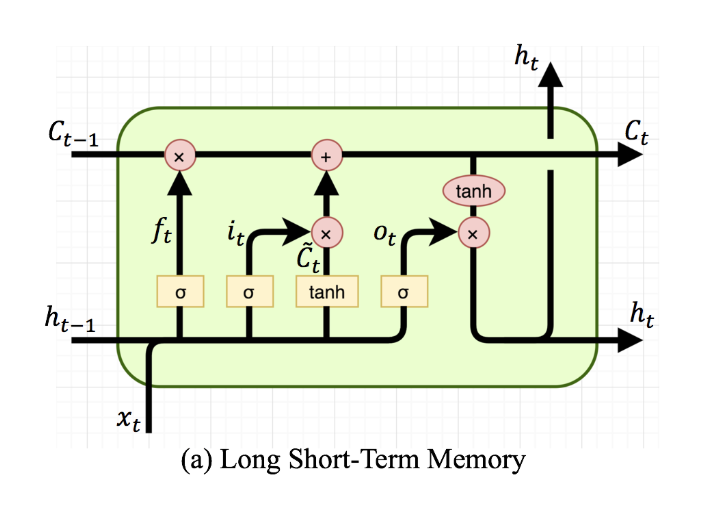

In [ ]:
in_features = 100
out_features = 10
num_seq = 2
N = 3

In [ ]:
model1 = nn.LSTM(in_features,out_features,num_layers=1)

In [ ]:
for param in model1.parameters():
    print(param.shape)

torch.Size([40, 100])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])


In [ ]:
class MyLSTM(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.Wx = torch.zeros(4 * out_features, in_features)
        self.Wh = torch.zeros(4 * out_features, out_features) 
        self.bx = torch.zeros(4 * out_features)
        self.bh = torch.zeros(4 * out_features)
        
    def forward(self, x, h=None, c=None):
        if h is None or c is None:
            _, N, _ = x.shape
            h = torch.zeros(N, self.out_features)
            c = torch.zeros(N, self.out_features)
        Wii = self.Wx[0:self.out_features,:]
        Wif = self.Wx[self.out_features:2*self.out_features,:]
        Wig = self.Wx[2*self.out_features:3*self.out_features,:]
        Wio = self.Wx[3*self.out_features:,:]
        
        bii = self.bx[0:self.out_features]
        bif = self.bx[self.out_features:2*self.out_features]
        big = self.bx[2*self.out_features:3*self.out_features]
        bio = self.bx[3*self.out_features:]
        
        Whi = self.Wh[0:self.out_features,:]
        Whf = self.Wh[self.out_features:2*self.out_features,:]
        Whg = self.Wh[2*self.out_features:3*self.out_features,:]
        Who = self.Wh[3*self.out_features:,:]
        
        bhi = self.bh[0:self.out_features]
        bhf = self.bh[self.out_features:2*self.out_features]
        bhg = self.bh[2*self.out_features:3*self.out_features]
        bho = self.bh[3*self.out_features:]
        
        o = []
        for x_ in x:
            it = torch.sigmoid(x_ @ Wii.T + bii + h @ Whi.T + bhi)
            ft = torch.sigmoid(x_ @ Wif.T + bif +  h @ Whf.T + bhf)
            gt = torch.tanh(x_ @ Wig.T + big + h @ Whg.T + bhg)
            ot = torch.sigmoid(x_ @ Wio.T + bio +  h @ Who.T + bho)
            c = ft * c + it * gt
            h = ot * torch.tanh(c)
            o.append(h)
        
        return o, (h, c)

In [ ]:
model2 = MyLSTM(100,10)

In [ ]:
params = [param for param in model1.parameters()]

In [ ]:
model2.Wx.data = params[0].data
model2.Wh.data = params[1].data
model2.bx.data = params[2].data
model2.bh.data = params[3].data

In [ ]:
dummy_x = torch.zeros(num_seq,N,in_features)

In [ ]:
o1, (h1,c1) = model1(dummy_x)
o2, (h2,c2) = model2(dummy_x)

In [ ]:
o1,o2

(tensor([[[ 1.5911e-02, -6.1369e-02, -1.6745e-02, -2.2932e-02,  4.4828e-05,
            3.8008e-02, -6.9839e-02, -5.8833e-03, -5.6772e-02,  1.3551e-02],
          [ 1.5911e-02, -6.1369e-02, -1.6745e-02, -2.2932e-02,  4.4828e-05,
            3.8008e-02, -6.9839e-02, -5.8833e-03, -5.6772e-02,  1.3551e-02],
          [ 1.5911e-02, -6.1369e-02, -1.6745e-02, -2.2932e-02,  4.4828e-05,
            3.8008e-02, -6.9839e-02, -5.8833e-03, -5.6772e-02,  1.3551e-02]],
 
         [[ 2.1364e-02, -9.2228e-02, -2.2119e-02, -4.1544e-02, -2.7059e-03,
            6.4267e-02, -1.0389e-01, -3.9033e-03, -8.2225e-02,  2.4741e-02],
          [ 2.1364e-02, -9.2228e-02, -2.2119e-02, -4.1544e-02, -2.7059e-03,
            6.4267e-02, -1.0389e-01, -3.9033e-03, -8.2225e-02,  2.4741e-02],
          [ 2.1364e-02, -9.2228e-02, -2.2119e-02, -4.1544e-02, -2.7059e-03,
            6.4267e-02, -1.0389e-01, -3.9033e-03, -8.2225e-02,  2.4741e-02]]],
        grad_fn=<StackBackward0>),
 [tensor([[ 1.5911e-02, -6.1369e-02, -1.67

Usando LSTM (Long-Short term memory) para speech recognition

In [ ]:
train_ds = MySpectrogramDataset(sc_train_ds)
test_ds = MySpectrogramDataset(sc_test_ds)

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32,shuffle=True)

In [ ]:
for x,y in train_dl:
  print(x.shape)
  print(y)
  break

torch.Size([32, 1, 81, 101])
tensor([27, 19, 13, 29, 34, 16,  5, 30,  8, 17, 27, 33, 11, 21,  9, 24,  7,  6,
         5, 22,  7, 17,  0, 21, 19, 22,  8, 12, 11, 34, 13,  5])


In [ ]:
class MyRNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(81,16,2,batch_first=True)
    self.flatten = nn.Flatten()
    self.classifier = nn.Linear(16*101,35)
  def forward(self, x):
    x = x.reshape((-1,81,101)).transpose(2,1)
    o, (h,c) = self.lstm(x)
    return self.classifier(self.flatten(o))

In [ ]:
model = MyRNN().to(dev)

In [ ]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(),lr=0.1)
train(model,train_dl, test_dl, crit,optim,epochs=10)

epoch: 0, train loss: 2.362145735037992, train acc: 33.34040521905166%, test loss: 1.6752478674400684, test acc: 52.20354384370741%
epoch: 1, train loss: 1.4466815357901393, train acc: 58.39963226194265%, test loss: 1.4582744573437891, test acc: 58.48250795093139%
epoch: 2, train loss: 1.1636796311150848, train acc: 66.35903963791945%, test loss: 1.2468212104813998, test acc: 64.46160835983643%
epoch: 3, train loss: 1.0210319036564497, train acc: 70.26389920205555%, test loss: 1.069501391243796, test acc: 68.39618355293048%
epoch: 4, train loss: 0.9288889073835599, train acc: 72.80270617493488%, test loss: 1.0236324436616067, test acc: 70.24988641526579%
epoch: 5, train loss: 0.8788157914333933, train acc: 74.29133811864267%, test loss: 0.9737023355136084, test acc: 71.39482053611995%
epoch: 6, train loss: 0.8456303366371409, train acc: 75.16118006199686%, test loss: 0.8687089470236801, test acc: 74.31167651067696%
epoch: 7, train loss: 0.7986788315302377, train acc: 76.28325259597138%

In [ ]:
torch.save(model.state_dict(),"speech_commands_lstm.ckpt")

In [ ]:
model.load_state_dict(torch.load("speech_commands_lstm.ckpt"))

In [ ]:
idx = 5000
audio_ = Audio(data=sc_test_ds[idx][0][0].numpy(),rate=16000)
pred = torch.argmax(model(test_ds[idx][0].reshape(1,1,81,101).to(dev)).cpu(),axis=1)[0].item()
print(speech_labels[pred])
display(audio_)

Sheila
